# Tutorial 3

- Name: Siddhant Midha
- Roll no.: 200070078
- *Declaration*. I have adhered to the academic code of conduct and will do so in the future as well.

In [111]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
from numpy import sqrt, pi
plt.rcParams.update({'font.size': 22 })
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from scipy.sparse import csr_matrix
from qutip import *
import scipy

### Note:: Assume PBC in all cases.

## Lanczos Diagonalization of the Heisenberg antiferromagnetic (J>0) chain.

## Hamiltonian 
**Heisenberg Hamiltonian (for chain)**: 


\begin{equation}
\mathcal{H}=  J\sum\limits_{i}\hat{S}_{i}\cdot\hat{S}_{i+1} = J\sum\limits_{i}H_{i,i+1}
\end{equation}



## Basic Idea:

* Since the full ED becomes practically intractable with the exponential increase in Hilbert space size, lanczos method is an alternative where a systematic construction of a basis (Krylov space) set (typically $\sim 100, 200, \ldots$) is done. This newly created basis approximately projects the system into low-energy states. Since, the basis size doesn't scale exponentially,  this also allows to go for larger system sizes (e.g. 20, 24, ...). Lowest energy states contribute significantly only at low-temperatures. So, the lanczos gives the details of the system effectively at low-temperatures. 



## Lanczos theory:

Important step that differs from full ED is in the entire Lanczos diagonalization is the '**Construction of Lanczos vectors' (say $\{ | \phi \rangle\}\equiv ( |\phi_0\rangle, |\phi_1\rangle, |\phi_2\rangle, |\phi_3\rangle,\ldots )$)**


### Construction of Krylov space:
* Start with trial state, say $|\psi_0\rangle$.

Example:

$$1^{\text{st}} \text{ basis state:  }\quad |\phi_0\rangle = \frac{|\psi_0\rangle}{\tilde{N}_0}, \quad \tilde{N}_0 = \langle \psi_0 | \psi_0 \rangle$$
$$ 2^{\text{nd}} \text{ basis state: }\quad |\phi_1\rangle = \frac{H|\psi_0\rangle - H_{00}|\psi_0\rangle}{\tilde{N}_1}$$
$$\quad\quad\quad\quad\quad\quad\quad \vdots$$
$$ n^{\text{th}} \text{ basis state: }\quad |\phi_{n+1}\rangle= \frac{H|\psi_n\rangle - H_{nn}|\psi_n\rangle - H_{n-1,n}|\psi_{n-1}\rangle}{\tilde{N}_{n+1}}$$

For the action of Hamiltonian on some state, one can optimize due to the sparse nature of local Hamiltonians instead of full matrix-vector multiplication. You can use Python's in-built functions for sparse matrices, e.g. see documentation of "scipy.sparse". Once the (tridiagonal) Hamiltonian is constructed in the above basis (as discussed in class), you can diagonalize it as in previous tutorials.

## Problem 1: Lanczos diagonalization.
### Questions:
1. Show/Plot the convergence of first four lowest energy states for L=12 (without full reorthogonalization)
2. Show/Plot the convergence of first four lowest energy states for L=12 (with full reorthogonalization)
3. Compare ground state energy value with exact diagonalization value.


In [2]:
def create_statedict(L):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    states_dict = {}
    for i in range((D)):
        state = bin(i)[2:]
        state = '0'*(L-len(state)) + state 
        states_dict[i] = state 
    return states_dict
def flipbits(state,i,j):
    copystate = state 
    copystate = list(copystate)
    bit_i = state[i]
    bit_j = state[j]
    if bit_i == '0':
        copystate[i] = '1'
    else:
        copystate[i] = '0'
    if bit_j == '0':
        copystate[j] = '1'
    else:
        copystate[j] = '0'
    copystate = ''.join(copystate)
    return copystate

def heisen_hamil(L,J,state_dict,BC='closed'):
    d = 2 #local Hilbert space dimension
    D = int(d ** L) #total Hilbert space direction
    H = np.zeros((D,D))
    sites = L-2 if BC == 'open' else L-1
    for site in range(sites):
        # print(H[1,1])
        #loop over i = 0,1,...,L-2 as there are total L-1 2-local terms in OBC
        for i in range(D):
                state = state_dict[i]
                #diagonal part
                s_site = 2 * int(state[site]) - 1
                s_nextsite = 2 * int(state[(site+1)%L]) - 1 
                H[i,i] += s_site * s_nextsite * 1/4
                
                #off-diagonal part
                if state[site] != state[(site+1)%L]:
                    nextstate = flipbits(state,site,(site+1)%L)
                    j  = int(nextstate,2)
                    H[i,j] += 1/2
    return H

def actH(state):
    #state is a 2 ** L dim vector
    H_sp = csr_matrix(H)
    return H_sp.dot(state)

def inner_pdt(state1,state2):
    return np.sum(np.conjugate(state1) * state2) 
    
def add_dim(mat):
    n, n = np.shape(mat)
    mat_ = np.zeros((n+1,n+1))
    mat_[:n,:n] = mat
    return mat_

In [3]:
np.random.seed(124)

In [31]:
J = 1 
L = 12
state_dict = create_statedict(L)
H = heisen_hamil(L,J,state_dict)
eigenvalues, eigenvectors = np.linalg.eig(H)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED = eigenvalues[sorted_indices]

In [4]:
def lanczos(H,ITER=100,conv_check=False,reortho=False):
    arr1 = []
    arr2 = []
    arr3 = []
    arr4 = []

    M = H.shape[0]
    lancvec_mat = np.zeros((M,ITER+1))
    diag = np.zeros(ITER)
    offdiag = np.zeros(ITER)

    lancvec_mat[:,0] = np.random.normal(size = M)
    lancvec_mat[:,0] /= sqrt(inner_pdt(lancvec_mat[:,0],lancvec_mat[:,0]))

    for jj in tqdm(range(ITER)):
        lancvec_mat[:,jj+1] = actH(lancvec_mat[:,jj])
        diag[jj] = inner_pdt(lancvec_mat[:,jj],lancvec_mat[:,jj+1])
        lancvec_mat[:,jj+1] -= diag[jj] * (lancvec_mat[:,jj])
        if jj != 0:
            lancvec_mat[:,jj+1] -= offdiag[jj-1] * lancvec_mat[:,jj-1]
        offdiag[jj] = sqrt(inner_pdt(lancvec_mat[:,jj+1],lancvec_mat[:,jj+1]))
        lancvec_mat[:,jj+1] /= offdiag[jj]

        if jj >= 3 and reortho == True:  
            for j in range(0,jj):
                norm = inner_pdt(lancvec_mat[:,jj+1], lancvec_mat[:,j])
                tempvec = lancvec_mat[:,jj+1] - norm * lancvec_mat[:,j]
                lancvec_mat[:,jj+1] = tempvec / sqrt(inner_pdt(tempvec,tempvec))
      
        if jj >= 4 and conv_check == True:
            H_lanc_temp = np.diag(diag[:jj]) + np.diag(offdiag[:jj-1], 1) + np.diag(offdiag[:jj-1], -1)
            v, _ = np.linalg.eigh(H_lanc_temp)
            sorted_indices = np.argsort(v)
            sorted_eigenvalues = v[sorted_indices]
            arr1.append(sorted_eigenvalues[0])
            arr2.append(sorted_eigenvalues[1])
            arr3.append(sorted_eigenvalues[2])
            arr4.append(sorted_eigenvalues[3])

    if conv_check:
        return arr1, arr2, arr3, arr4
    else:
        H_lanc = np.diag(diag) + np.diag(offdiag[:-1], 1) + np.diag(offdiag[:-1], -1)
        eigenvalues, eigenvectors = np.linalg.eigh(H_lanc)
        eigenvectors = lancvec_mat[:, :ITER] @ eigenvectors
        return eigenvalues, eigenvectors


## no reortho

100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Text(0, 0.5, '$E$')

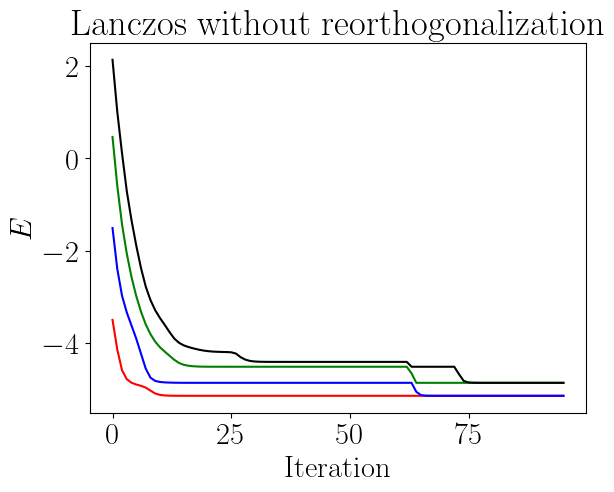

In [33]:
arr1, arr2, arr3, arr4 = lanczos(H=H,ITER=100,conv_check=True,reortho=False)
plt.title('Lanczos without reorthogonalization')
plt.plot(arr1,color='red')
plt.plot(arr2,color='blue')
plt.plot(arr3,color='green')
plt.plot(arr4,color='black')
plt.xlabel('Iteration')
plt.ylabel('$E$')

## with reortho

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Text(0, 0.5, '$E$')

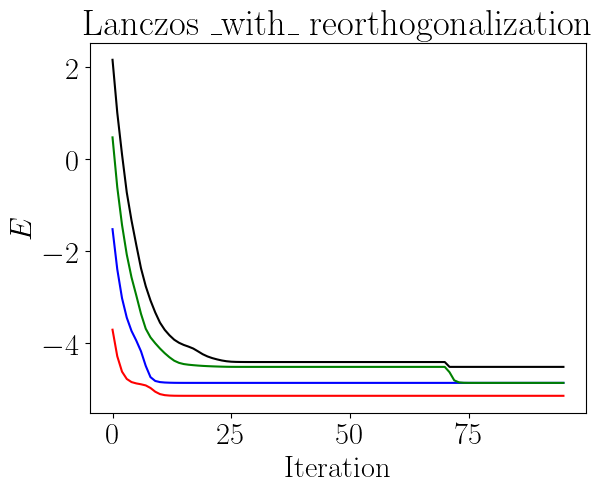

In [34]:
arr1, arr2, arr3, arr4 = lanczos(H=H,ITER=100,conv_check=True,reortho=True)
plt.title('Lanczos _with_ reorthogonalization')
plt.plot(arr1,color='red')
plt.plot(arr2,color='blue')
plt.plot(arr3,color='green')
plt.plot(arr4,color='black')
plt.xlabel('Iteration')
plt.ylabel('$E$')

100%|██████████| 50/50 [00:07<00:00,  6.92it/s]


([<matplotlib.axis.XTick at 0x16aa8aad0>,
 [Text(0, 0, 'E.D.'),
  Text(1, 0, '10 Iter'),
  Text(2, 0, '20 Iter'),
  Text(3, 0, '30 Iter'),
  Text(4, 0, '40 Iter'),
  Text(5, 0, '50 Iter')])

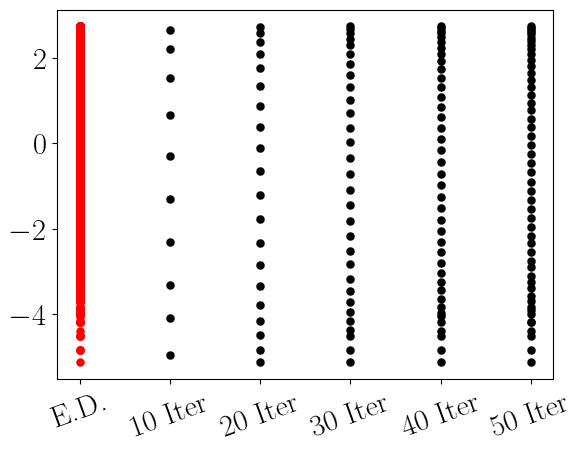

In [37]:
for ii in range(1,6):
    eigenvalues, eigenvectors = lanczos(H=H,ITER=10 * ii,conv_check=False,reortho=True)
    for ee in eigenvalues:
        plt.scatter(x=ii,y =ee, color='black',linewidth=0.1)


for ee in sorted_eigenvalues_ED:
    plt.scatter(x=0,y = ee, color='red',linewidth=0.1)


plt.xticks(range(6), ['E.D.', '10 Iter', '20 Iter', '30 Iter', '40 Iter', '50 Iter'],
       rotation=20)

## Problem 2: Correlation function, $\mathcal{C}_r$

* Since full spectrum is never accurate in lanczos method, we therefore calculate the observables in the groundstate which is relevant to low-temperature physics.

### Spin-spin correlations case:
* The correlation function $\mathcal{C}_r$ is very commonly-used quantity as well as a physically meaningful one. It is often defined as:
\begin{equation}\mathcal{C}_r = \langle \hat{S}_i \cdot \hat{S}_{i+r}\rangle\end{equation}


### Questions:
1. Calculate and plot the ground state correlation function as a function of 'r' using exact diagonalization and Lanczos diagonalization in $M_z=0$ sector  for L = 16.
2. Do the same for the first two excited states in $M_z=0$ sector for L = 16.

In [117]:
def sum_str(str):
    s = np.sum([2*int(bit)-1 for bit in list(str)])
    return s
def actH(state):
    #state is a M dim vector
    H_sp = csr_matrix(hamil)
    return H_sp.dot(state)



def find_ind(state,lookups):
    #state is in binary
    mag = sum_str(state)
    lookup = lookups[mag]
    low = 0
    high = len(lookup)
    mid = int(len(lookup)/2)
    while True:
        if int(lookup[mid],2) < int(state,2):
            low = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) > int(state,2):
            high = mid
            mid = int((low+high)/2)
        elif int(lookup[mid],2) == int(state,2):
            return mag, mid 
        
def create_mag_lookups(L,state_dict):
    lookups = {}
    for mag in range(-L,L+1):
        ctr = 0
        lookup = {}
        for i in range(2**L):
            state = state_dict[i]
            if sum_str(state) == mag:
                lookup[ctr] = state 
                ctr += 1
        lookups[mag] = lookup
    return lookups


def create_hamil_mag(L,J,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L):
        for i in range(dim):
            state = lookup[i]
            #diagonal part
            s_site = 2 * int(state[site]) - 1
            s_nextsite = 2 * int(state[(site+1)%L]) - 1 
            ham[i,i] += s_site * s_nextsite * 1/4

            #off-diagonal part
            if state[site] != state[(site+1)%L]:
                nextstate = flipbits(state,site,(site+1)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 1/2
    return ham * J

# computing observibles

$$\ket{\psi} = \sum_{\sigma}c_{\sigma}\ket{\sigma}$$
$$\langle S_i^zS_j^z\rangle = \sum_{\sigma,\sigma'}c_{\sigma}c_{\sigma'}^* \langle\sigma'|S_i^zS_j^z|\sigma\rangle = \sum_{\sigma,\sigma'}\delta_{\sigma,\sigma'} c_{\sigma}c_{\sigma'}^*s_i^zs_j^z = \sum_{\sigma}|c_{\sigma}|^2 \sigma_i\sigma_j $$
with $\sigma_i\sigma_j \in \{\pm 0.25\}$



Now, let $$\mathcal{O} := \frac{S_i^+S_j^- +  S_i^-S_j^+}{2}$$
$$\langle \mathcal{O}\rangle = \sum_{\sigma,\sigma'}c_{\sigma}c_{\sigma'}^* \langle\sigma'|\mathcal{O}|\sigma\rangle = 0.5\sum_{\sigma,\sigma'}c_{\sigma}c_{\sigma'}^*\delta_{\sigma_i \neq \sigma_j}\delta_{\sigma'=Flip_{ij}(\sigma)} = 0.5\sum_{\sigma: \sigma_i \neq \sigma_j}c_{\sigma}c_{\sigma'=Flip_{ij}(\sigma)}^*$$

In [118]:
def compute_corr(i,j,input_state,lookups):
    #i,j = 0,1,...,L-1
    #state is in Mz
    m = len(input_state)
    lookup = lookups[0]
    summ = 0
    for ctr in range(m):
        state = lookup[ctr]
        sz_i = 2 * int(state[i]) - 1
        sz_j = 2 * int(state[j]) - 1 
        summ += 0.25 * sz_i * sz_j * np.abs(input_state[ctr]) ** 2
        if sz_i != sz_j:
            flipped = flipbits(state,i,j)
            _, mid = find_ind(flipped,lookups)
            summ += 0.5 * input_state[ctr] * np.conj(input_state[mid])
    return summ

In [119]:
L = 16
J = 1
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
hamil = create_hamil_mag(L,J,mag=0,lookups=lookups)


In [120]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_2 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_2 = eigenvectors[:, sorted_indices]

In [121]:
eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lanc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lanc = eigenvectors[:, sorted_indices]
gs_Lanc = sorted_eigenvectors_Lanc[:,0]


100%|██████████| 100/100 [05:36<00:00,  3.37s/it]


In [122]:
ref_site = 0
gs_ED_2 = sorted_eigenvectors_ED_2[:,0]

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lanc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_2,lookups)

/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/208138420.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_2,lookups)


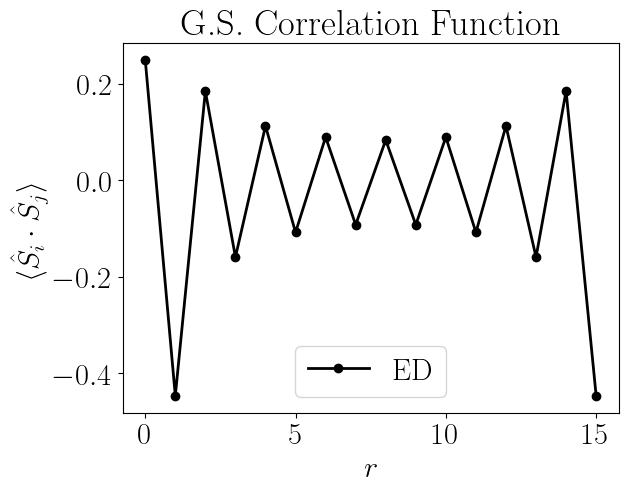

In [124]:
plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function')
plt.legend()

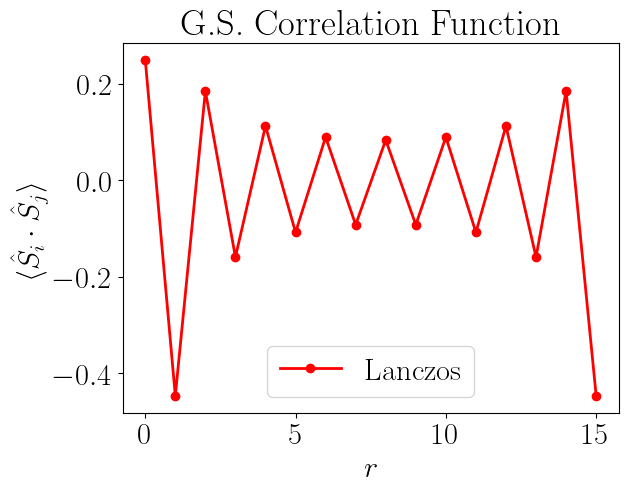

In [125]:
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function')
plt.legend()

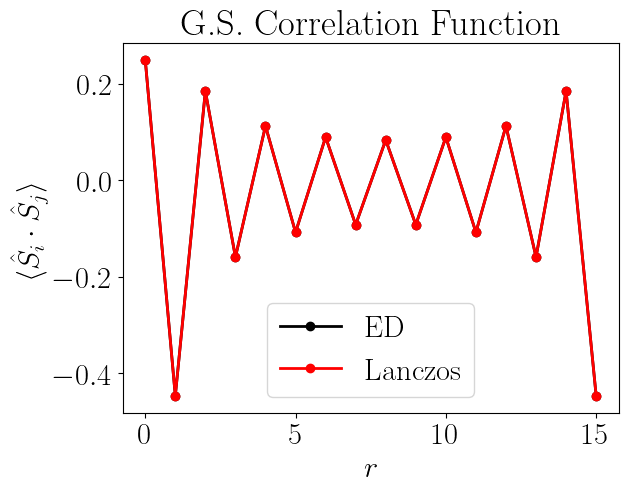

In [126]:
plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function')
plt.legend()

In [127]:
ex1_ED_2 = sorted_eigenvectors_ED_2[:, 1]
ex2_ED_2 = sorted_eigenvectors_ED_2[:, 2]
ex1_Lanc = sorted_eigenvectors_Lanc[:, 1]
ex2_Lanc = sorted_eigenvectors_Lanc[:, 2]

In [129]:
ref_site = 0

corr_ex1_ED_2 = np.zeros(L)
corr_ex2_ED_2 = np.zeros(L)
corr_ex1_Lanc = np.zeros(L)
corr_ex2_Lanc = np.zeros(L)


for ii in range(L):
    corr_ex1_ED_2[ii] = compute_corr(0,ii,ex1_ED_2,lookups)
    corr_ex2_ED_2[ii] = compute_corr(0,ii,ex2_ED_2,lookups)
    corr_ex1_Lanc[ii] = compute_corr(0,ii,ex1_Lanc,lookups)
    corr_ex2_Lanc[ii] = compute_corr(0,ii,ex2_Lanc,lookups)


/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/2228801426.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ex1_ED_2[ii] = compute_corr(0,ii,ex1_ED_2,lookups)
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/2228801426.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ex2_ED_2[ii] = compute_corr(0,ii,ex2_ED_2,lookups)


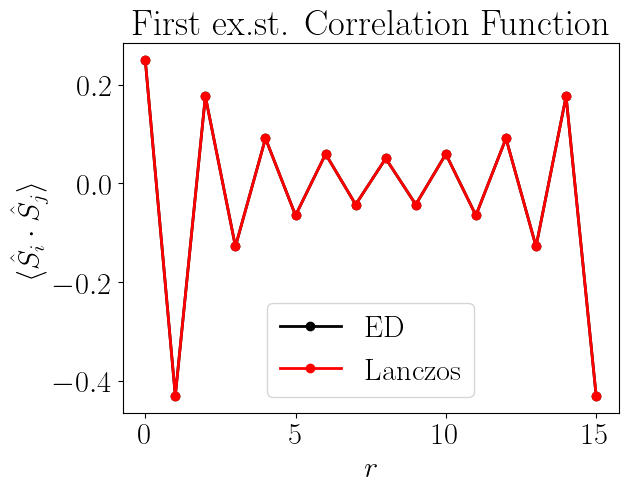

In [130]:
plt.plot(range(L),corr_ex1_ED_2,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_ex1_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'First ex.st. Correlation Function')
plt.legend()

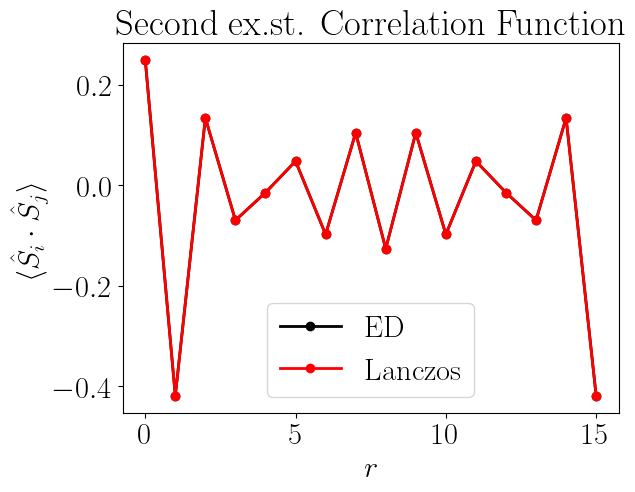

In [131]:
plt.plot(range(L),corr_ex2_ED_2,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_ex2_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'Second ex.st. Correlation Function')
plt.legend()

## Problem 3: Correlation function in MG model

$$H = J_{1}\sum_{ i}S_{i}.S_{i+1} + J_{2}\sum_{ i}S_{i}.S_{i+2}$$  
where both $J_{1}$ and $J_{2}$ are positive and g is defined as $g=\frac{J_{2}}{J_{1}}$. $C_{r}$ is defined same as above.


## Questions:
1. Calculate and plot the ground state correlation function as a function of 'r' using exact diagonalization and Lanczos diagonalization in $M_z=0$ sector  for L = 12 for $g \in (0.0, 0.25, 0.50, 0.75, 1.0)$
2. Plot $C_{r} (r=\frac{L}{2}) $ vs $\frac{1}{L}$ for different value of L = 10,12,14,16 for $g \in (0.0, 0.25, 0.50, 0.75, 1.0)$ using Lanczos diagonalization. Can you say something about the phase transition in this model from this plot ?

In [134]:

def create_hamil_mag(L,J1,J2,mag,lookups):
    lookup = lookups[mag]
    dim = len(lookup)
    ham = np.zeros((dim,dim))
    for site in range(L):
        for i in range(dim):
            state = lookup[i]
            #diagonal part J1
            s_site = 2 * int(state[site]) - 1
            s_nextsite = 2 * int(state[(site+1)%L]) - 1 
            ham[i,i] += s_site * s_nextsite * 1/4 * J1
            #diagonal part J2
            s_site = 2 * int(state[site]) - 1
            s_nextsite = 2 * int(state[(site+2)%L]) - 1 
            ham[i,i] += s_site * s_nextsite * 1/4 * J2

            #off-diagonal part J1
            if state[site] != state[(site+1)%L]:
                nextstate = flipbits(state,site,(site+1)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 1/2 * J1

            #off-diagonal part J2
            if state[site] != state[(site+2)%L]:
                nextstate = flipbits(state,site,(site+2)%L) # will always be in the same magnetization sector!
                mag_, j = find_ind(nextstate,lookups)
                if mag != mag_:
                    return "ERROR ERROR!!"
                ham[i,j] += 1/2 * J2

    return ham 

100%|██████████| 100/100 [00:01<00:00, 80.66it/s]
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/489131215.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


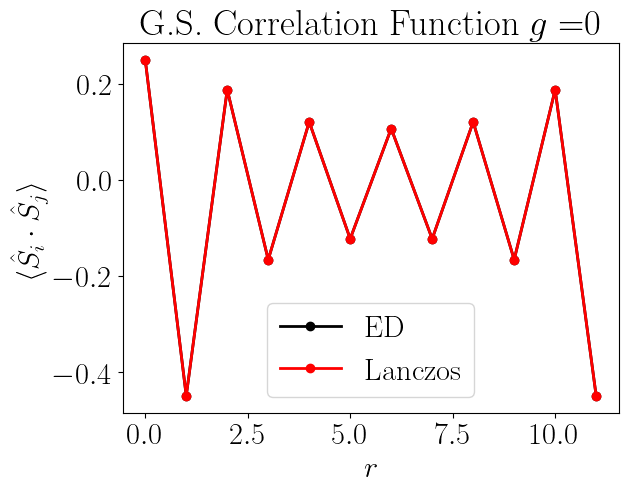

In [135]:
g = 0

J1 = 1
L = 12
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
J2 = J1 * g


hamil = create_hamil_mag(L,J1,J2,0,lookups)

eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_3 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_3 = eigenvectors[:, sorted_indices]
gs_ED_3 = sorted_eigenvectors_ED_3[:,0]

eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
gs_Lancc = sorted_eigenvectors_Lancc[:,0]

ref_site = 0

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lancc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $g = $'+str(g))
plt.legend()

100%|██████████| 100/100 [00:01<00:00, 77.43it/s]
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/1225133295.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


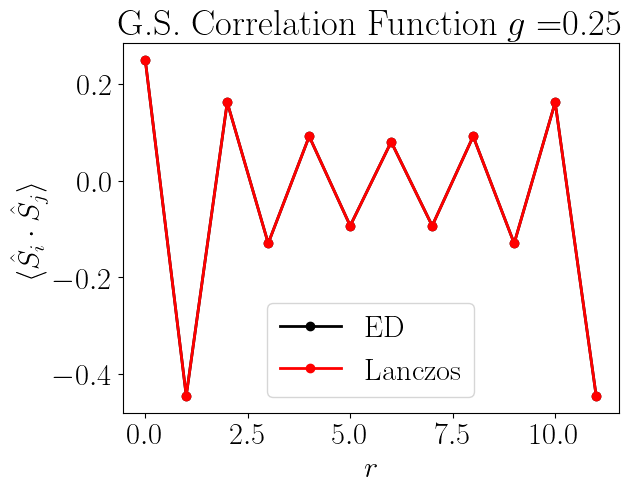

In [136]:
g = 0.25

J1 = 1
L = 12
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
J2 = J1 * g


hamil = create_hamil_mag(L,J1,J2,0,lookups)

eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_3 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_3 = eigenvectors[:, sorted_indices]
gs_ED_3 = sorted_eigenvectors_ED_3[:,0]

eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
gs_Lancc = sorted_eigenvectors_Lancc[:,0]

ref_site = 0

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lancc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $g = $'+str(g))
plt.legend()

100%|██████████| 100/100 [00:01<00:00, 78.69it/s]
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/3119185519.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


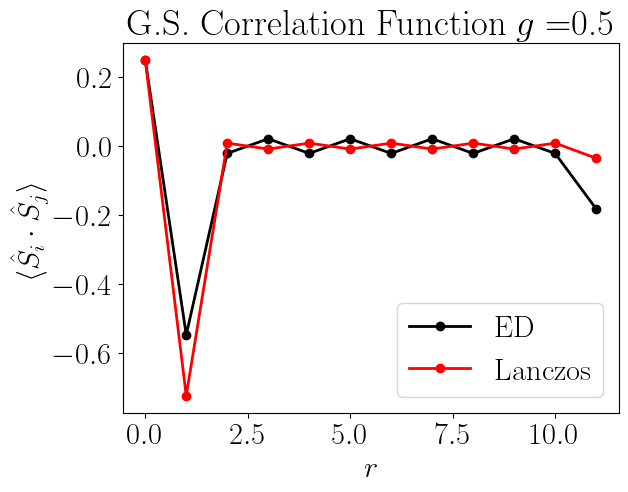

In [137]:
g = 0.5

J1 = 1
L = 12
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
J2 = J1 * g


hamil = create_hamil_mag(L,J1,J2,0,lookups)

eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_3 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_3 = eigenvectors[:, sorted_indices]
gs_ED_3 = sorted_eigenvectors_ED_3[:,0]

eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
gs_Lancc = sorted_eigenvectors_Lancc[:,0]

ref_site = 0

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lancc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $g = $'+str(g))
plt.legend()

100%|██████████| 100/100 [00:01<00:00, 78.69it/s]
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/3855746417.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


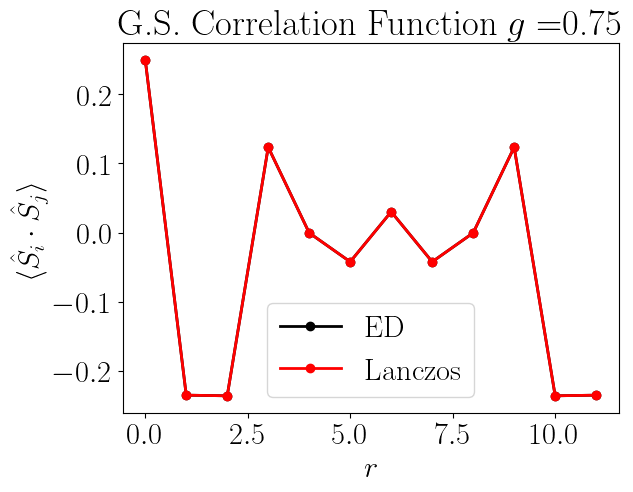

In [138]:
g = 0.75

J1 = 1
L = 12
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
J2 = J1 * g


hamil = create_hamil_mag(L,J1,J2,0,lookups)

eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_3 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_3 = eigenvectors[:, sorted_indices]
gs_ED_3 = sorted_eigenvectors_ED_3[:,0]

eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
gs_Lancc = sorted_eigenvectors_Lancc[:,0]

ref_site = 0

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lancc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $g = $'+str(g))
plt.legend()

100%|██████████| 100/100 [00:01<00:00, 79.46it/s]
/var/folders/bv/ml429ql15qs_qzphdftwk2vw0000gn/T/ipykernel_11567/3120441364.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


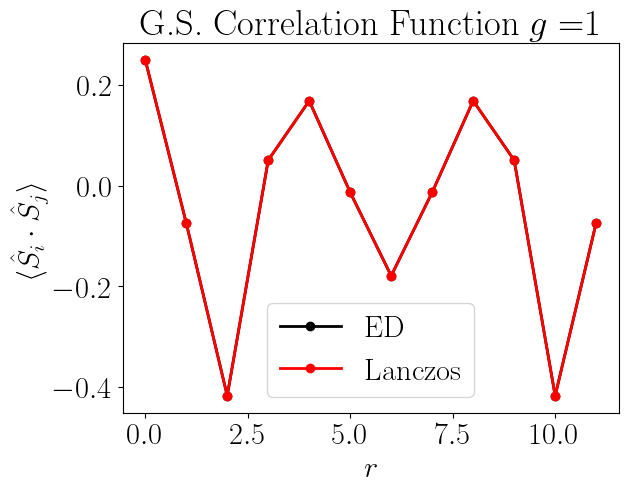

In [139]:
g = 1

J1 = 1
L = 12
state_dict = create_statedict(L=L)
lookups = create_mag_lookups(L,state_dict)
J2 = J1 * g


hamil = create_hamil_mag(L,J1,J2,0,lookups)

eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(hamil)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_ED_3 = eigenvalues[sorted_indices]
sorted_eigenvectors_ED_3 = eigenvectors[:, sorted_indices]
gs_ED_3 = sorted_eigenvectors_ED_3[:,0]

eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
gs_Lancc = sorted_eigenvectors_Lancc[:,0]

ref_site = 0

corr_ED = np.zeros(L)
corr_Lanc = np.zeros(L)

for ii in range(L):
    corr_Lanc[ii] = compute_corr(0,ii,gs_Lancc,lookups)
    corr_ED[ii] = compute_corr(0,ii,gs_ED_3,lookups)


plt.plot(range(L),corr_ED,'-o',color='black',linewidth=2,label='ED')
plt.plot(range(L),corr_Lanc,'-o',color='red',linewidth=2,label='Lanczos')
plt.xlabel(r'$r$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $g = $'+str(g))
plt.legend()

In [150]:
J1 = 1

def give_corr(g,L):
    global hamil    
    state_dict = create_statedict(L=L)
    lookups = create_mag_lookups(L,state_dict)
    J2 = J1 * g
    hamil = create_hamil_mag(L,J1,J2,0,lookups)
    eigenvalues, eigenvectors = lanczos(H=hamil,ITER=100,conv_check=False,reortho=True)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues_Lancc = eigenvalues[sorted_indices]
    sorted_eigenvectors_Lancc = eigenvectors[:, sorted_indices]
    gs_Lancc = sorted_eigenvectors_Lancc[:,0]
    corr = compute_corr(0,int(L/2),gs_Lancc,lookups)
    return corr

L_arr = [10,12,14,16]


100%|██████████| 100/100 [05:51<00:00,  3.52s/it]


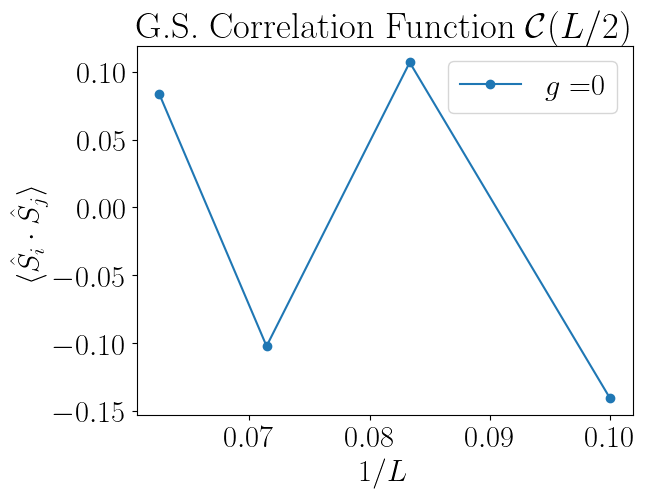

In [151]:
g = 0
plt.plot(1/np.array(L_arr),[give_corr(g,L) for L in L_arr],'-o',label='$g = $' + str(g))
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $\mathcal{C}(L/2)$')
plt.legend()

100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


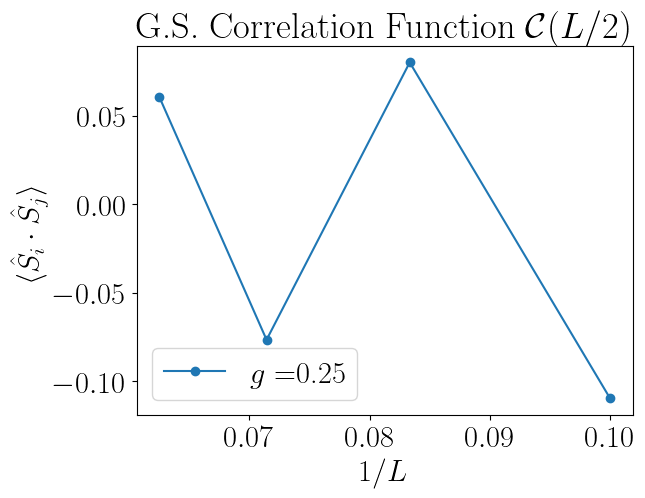

In [152]:
g = 0.25
plt.plot(1/np.array(L_arr),[give_corr(g,L) for L in L_arr],'-o',label='$g = $' + str(g))
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $\mathcal{C}(L/2)$')
plt.legend()

100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


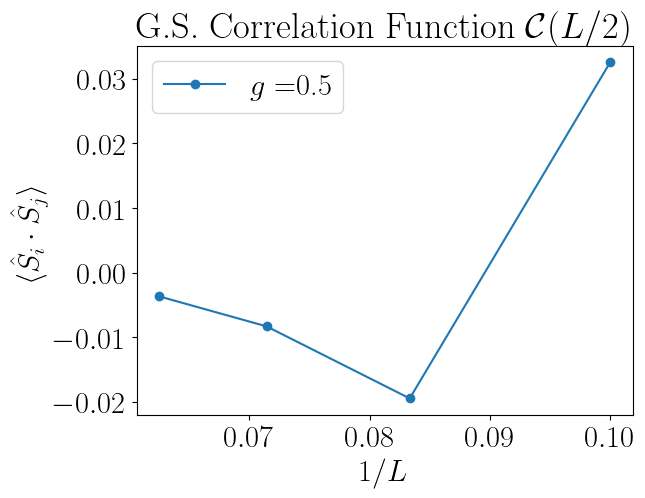

In [153]:
g = 0.5
plt.plot(1/np.array(L_arr),[give_corr(g,L) for L in L_arr],'-o',label='$g = $' + str(g))
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $\mathcal{C}(L/2)$')
plt.legend()

100%|██████████| 100/100 [05:56<00:00,  3.56s/it]


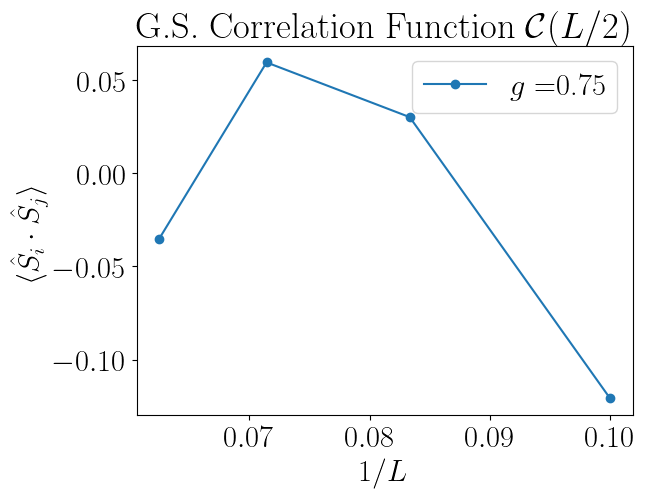

In [154]:
g = 0.75
plt.plot(1/np.array(L_arr),[give_corr(g,L) for L in L_arr],'-o',label='$g = $' + str(g))
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $\mathcal{C}(L/2)$')
plt.legend()

100%|██████████| 100/100 [05:35<00:00,  3.36s/it]


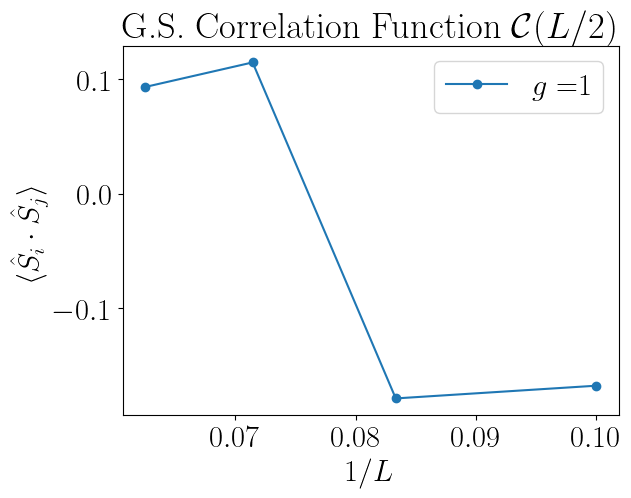

In [155]:
g = 1
plt.plot(1/np.array(L_arr),[give_corr(g,L) for L in L_arr],'-o',label='$g = $' + str(g))
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle \hat{S}_i\cdot\hat{S}_j\rangle$')
plt.title(r'G.S. Correlation Function $\mathcal{C}(L/2)$')
plt.legend()